In [1]:
import collections
import os
import pickle

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import transformers

from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
def textbf(text):
    return '\033[1m' + text + '\033[0m'

def textcolor(text, color):
    code = {'red': '31', 'green': '32', 'yellow': '33', 'blue': '34', 'magenta': '35', 'cyan': '36', 'white': '37'}
    return '\033[' + code[color] + 'm' + text + '\033[0m'

In [3]:
data_dir = '../data/N2C2-Track3-May3/'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'), low_memory=False)
print(f'Train {len(df_train)} rows')
df_dev = pd.read_csv(os.path.join(data_dir, 'dev.csv'), low_memory=False)
print(f'Dev {len(df_dev)} rows')

Train 4633 rows
Dev 597 rows


In [4]:
_relation_labels = {'Direct': 0, 'Indirect': 1, 'Neither': 2, 'Not Relevant': 3}
relations, labels = list(zip(*_relation_labels.items()))
relation_to_label = _relation_labels
label_to_relation = {v: k for k, v in relation_to_label.items()}
num_labels = len(relation_to_label)

## Accuracy / conf matrix

In [5]:
def confusion_matrix_strs(y_true, y_pred, dataset=''):
    conf_mat = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    results = []
    results.append(f'{dataset.upper():<9}' + ' '.join([f'{r[:8]:>8}' for r in relations]) + '  Lbl cnt')
    for i in range(4):
        results.append(f'{relations[i][:8]:>8} ' + ' '.join([f'{c:8}' for c in conf_mat[i]]) + f' {sum(conf_mat[i]):8}')    
    results.append(f'Pred cnt ' + ' '.join([f'{sum(conf_mat[:,i]):8}' for i in range(4)]) + f' {np.sum(conf_mat):8}')    
    return results

def plot_confusion_matrix_traindev(results_dir, ckpt_step=9999):
    print(f'[Experiment {results_dir}, step {ckpt_step}]')
    
    train_labels = np.array([relation_to_label[row['Relation']] for _, row in df_train.iterrows()])
    dev_labels = np.array([relation_to_label[row['Relation']] for _, row in df_dev.iterrows()])
    with open(os.path.join(results_dir, f'results_train_{ckpt_step}.pkl'), 'rb') as fd:
        train_results = pickle.load(fd)
    with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
        dev_results = pickle.load(fd)
    train_preds = np.argmax(np.array([r['logits'] for r in train_results]), axis=1)
    dev_preds = np.argmax(np.array([r['logits'] for r in dev_results]), axis=1)

    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay.from_predictions(y_true=train_labels, y_pred=train_preds, normalize='true', cmap=plt.cm.Blues, ax=ax)
    plt.title('Train prediction'); plt.xticks(*zip(*label_to_relation.items())); plt.yticks(*zip(*label_to_relation.items()))
    ax = plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay.from_predictions(y_true=dev_labels, y_pred=dev_preds, normalize='true', cmap=plt.cm.Blues, ax=ax)
    plt.title('Dev prediction'); plt.xticks(*zip(*label_to_relation.items())); plt.yticks(*zip(*label_to_relation.items()))

    train_correct = train_labels == train_preds
    dev_correct = dev_labels == dev_preds
    print(f'- Train set performance')
    print(f'    - Accuracy: {np.mean(train_correct):.6f} ({sum(train_correct)}/{len(train_correct)})')
    print(f'    - Macro F1: {sklearn.metrics.f1_score(y_true=train_labels, y_pred=train_preds, average="macro"):.6f}')
    print(f'- Dev set performance')
    print(f'    - Accuracy: {np.mean(dev_correct):.6f} ({sum(dev_correct)}/{len(dev_correct)})')
    print(f'    - Macro F1: {sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro"):.6f}')
    
    train_conf_strs = confusion_matrix_strs(train_labels, train_preds, 'train')
    dev_conf_strs = confusion_matrix_strs(dev_labels, dev_preds, 'dev')
    for str1, str2 in zip(train_conf_strs, dev_conf_strs):
        print(str1 + ' | ' + str2)

### Sentence Relation Model

[Experiment ../results/sent_rel_bert-base-uncased_noshuffle/, step 8000]
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.743719 (444/597)
    - Macro F1: 0.766184
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       13       17        1      145
Indirect        0     1249        0        0     1249 | Indirect       15      119       43        2      179
 Neither        0        0     1484        0     1484 |  Neither        7       41      123        2      173
Not Rele        0        0        0      810      810 | Not Rele        3        2        7       88      100
Pred cnt     1090     1249     1484      810     4633 | Pred cnt      139      175      190       93      597


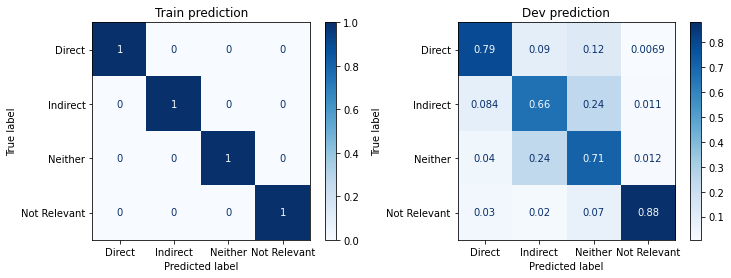

In [6]:
plot_confusion_matrix_traindev('../results/sent_rel_bert-base-uncased_noshuffle/', ckpt_step=8000)

[Experiment ../results/sent_rel_PubMedBERT_noshuffle/, step 9000]
- Train set performance
    - Accuracy: 0.999784 (4632/4633)
    - Macro F1: 0.999816
- Dev set performance
    - Accuracy: 0.785595 (469/597)
    - Macro F1: 0.803869
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      110       25        7        3      145
Indirect        0     1249        0        0     1249 | Indirect        8      132       37        2      179
 Neither        0        1     1483        0     1484 |  Neither        0       35      137        1      173
Not Rele        0        0        0      810      810 | Not Rele        4        2        4       90      100
Pred cnt     1090     1250     1483      810     4633 | Pred cnt      122      194      185       96      597


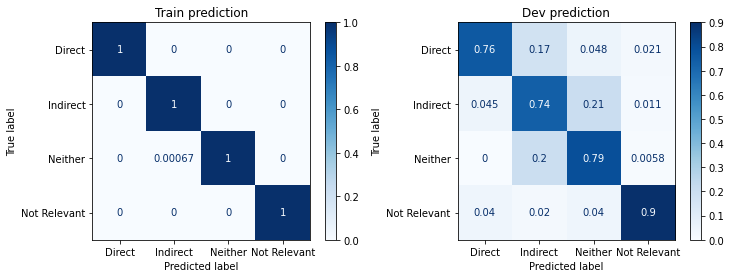

In [7]:
plot_confusion_matrix_traindev('../results/sent_rel_PubMedBERT_noshuffle/', ckpt_step=9000)

[Experiment ../results/sent_rel_BioClinicalBERT_noshuffle/, step 7000]
- Train set performance
    - Accuracy: 0.999352 (4630/4633)
    - Macro F1: 0.999416
- Dev set performance
    - Accuracy: 0.778894 (465/597)
    - Macro F1: 0.793371
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      110       21        7        7      145
Indirect        1     1246        2        0     1249 | Indirect       11      121       42        5      179
 Neither        0        0     1484        0     1484 |  Neither        2       28      139        4      173
Not Rele        0        0        0      810      810 | Not Rele        1        1        3       95      100
Pred cnt     1091     1246     1486      810     4633 | Pred cnt      124      171      191      111      597


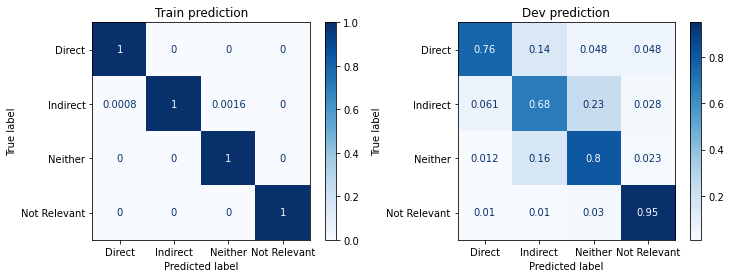

In [8]:
plot_confusion_matrix_traindev('../results/sent_rel_BioClinicalBERT_noshuffle/', ckpt_step=7000)

[Experiment ../results/sent_rel_BlueBERT-Base_noshuffle/, step 6000]
- Train set performance
    - Accuracy: 0.998705 (4627/4633)
    - Macro F1: 0.998863
- Dev set performance
    - Accuracy: 0.770519 (460/597)
    - Macro F1: 0.787364
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      116       20        7        2      145
Indirect        1     1245        3        0     1249 | Indirect       17      122       36        4      179
 Neither        0        2     1482        0     1484 |  Neither        0       37      134        2      173
Not Rele        0        0        0      810      810 | Not Rele        6        1        5       88      100
Pred cnt     1091     1247     1485      810     4633 | Pred cnt      139      180      182       96      597


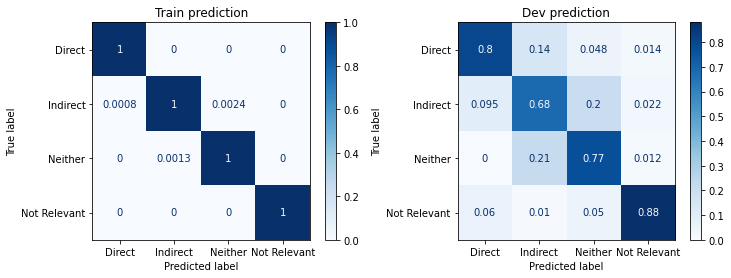

In [9]:
plot_confusion_matrix_traindev('../results/sent_rel_BlueBERT-Base_noshuffle/', ckpt_step=6000)

[Experiment ../results/sent_rel_BlueBERT-Large_noshuffle/, step 7000]
- Train set performance
    - Accuracy: 0.998273 (4625/4633)
    - Macro F1: 0.998450
- Dev set performance
    - Accuracy: 0.788945 (471/597)
    - Macro F1: 0.805841
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1089        0        1        0     1090 |   Direct      110       25       10        0      145
Indirect        2     1244        3        0     1249 | Indirect       13      134       31        1      179
 Neither        0        2     1482        0     1484 |  Neither        5       28      139        1      173
Not Rele        0        0        0      810      810 | Not Rele        4        3        5       88      100
Pred cnt     1091     1246     1486      810     4633 | Pred cnt      132      190      185       90      597


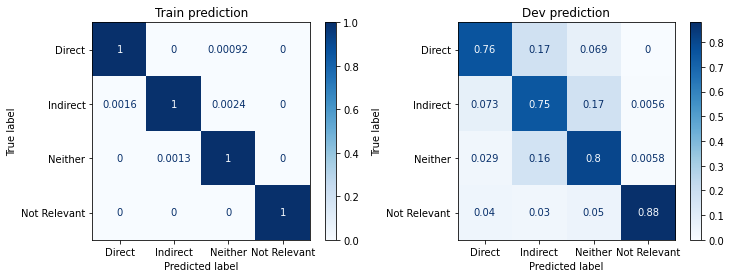

In [10]:
plot_confusion_matrix_traindev('../results/sent_rel_BlueBERT-Large_noshuffle/', ckpt_step=7000)

[Experiment ../results/sent_rel_Clinical-Longformer_noshuffle/, step 8000]
- Train set performance
    - Accuracy: 0.999137 (4629/4633)
    - Macro F1: 0.999148
- Dev set performance
    - Accuracy: 0.757119 (452/597)
    - Macro F1: 0.777702
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1088        2        0        0     1090 |   Direct      109       23       12        1      145
Indirect        0     1248        1        0     1249 | Indirect       13      128       38        0      179
 Neither        0        0     1484        0     1484 |  Neither        6       37      127        3      173
Not Rele        0        0        1      809      810 | Not Rele        4        1        7       88      100
Pred cnt     1088     1250     1486      809     4633 | Pred cnt      132      189      184       92      597


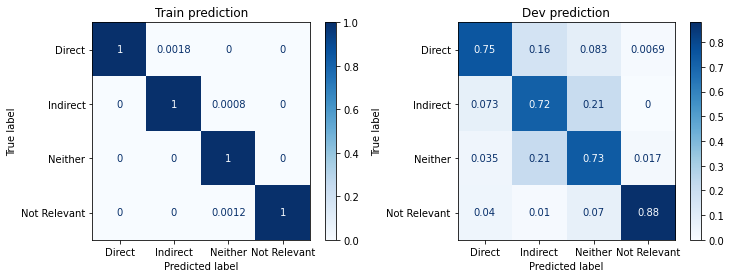

In [11]:
plot_confusion_matrix_traindev('../results/sent_rel_Clinical-Longformer_noshuffle/', ckpt_step=8000)

[Experiment ../results/sent_rel_Clinical-Longformer2_noshuffle/, step 9000]
- Train set performance
    - Accuracy: 0.999784 (4632/4633)
    - Macro F1: 0.999785
- Dev set performance
    - Accuracy: 0.763819 (456/597)
    - Macro F1: 0.784852
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1089        1        0        0     1090 |   Direct      104       28       12        1      145
Indirect        0     1249        0        0     1249 | Indirect        6      134       37        2      179
 Neither        0        0     1484        0     1484 |  Neither        3       39      130        1      173
Not Rele        0        0        0      810      810 | Not Rele        3        2        7       88      100
Pred cnt     1089     1250     1484      810     4633 | Pred cnt      116      203      186       92      597


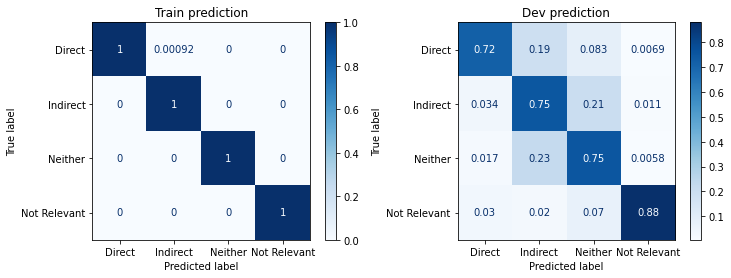

In [12]:
plot_confusion_matrix_traindev('../results/sent_rel_Clinical-Longformer2_noshuffle/', ckpt_step=9000)

### Sentence Similarity Model

[Experiment ../results/sent_sim_bert-base-uncased_noshuffle/, step 7000]
- Train set performance
    - Accuracy: 0.997626 (4622/4633)
    - Macro F1: 0.997586
- Dev set performance
    - Accuracy: 0.654941 (391/597)
    - Macro F1: 0.684530
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      105       38        2        0      145
Indirect       10     1239        0        0     1249 | Indirect       22      114       43        0      179
 Neither        0        0     1484        0     1484 |  Neither       12       67       88        6      173
Not Rele        1        0        0      809      810 | Not Rele        9        5        2       84      100
Pred cnt     1101     1239     1484      809     4633 | Pred cnt      148      224      135       90      597


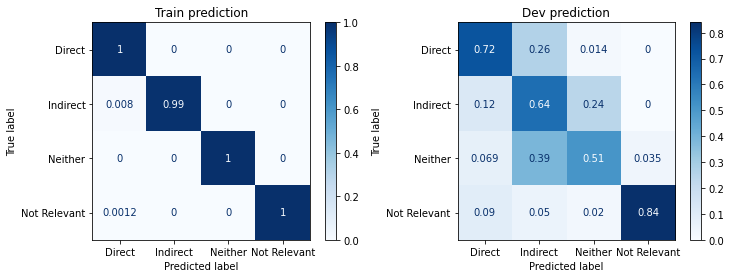

In [13]:
plot_confusion_matrix_traindev('../results/sent_sim_bert-base-uncased_noshuffle/', ckpt_step=7000)

[Experiment ../results/sent_sim2_bert-base-uncased_noshuffle/, step 9999]
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.666667 (398/597)
    - Macro F1: 0.694446
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct       89       45       11        0      145
Indirect        0     1249        0        0     1249 | Indirect       13      116       49        1      179
 Neither        0        0     1484        0     1484 |  Neither       10       49      109        5      173
Not Rele        0        0        0      810      810 | Not Rele        6        4        6       84      100
Pred cnt     1090     1249     1484      810     4633 | Pred cnt      118      214      175       90      597


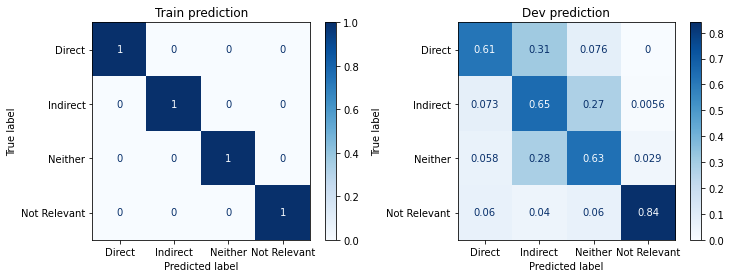

In [14]:
plot_confusion_matrix_traindev('../results/sent_sim2_bert-base-uncased_noshuffle/', ckpt_step=9999)

[Experiment ../results/sent_sim_PubMedBERT_noshuffle/, step 9999]
- Train set performance
    - Accuracy: 0.999568 (4631/4633)
    - Macro F1: 0.999601
- Dev set performance
    - Accuracy: 0.671692 (401/597)
    - Macro F1: 0.701512
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct       97       30       17        1      145
Indirect        1     1247        1        0     1249 | Indirect       16      104       56        3      179
 Neither        0        0     1484        0     1484 |  Neither       10       49      113        1      173
Not Rele        0        0        0      810      810 | Not Rele        7        4        2       87      100
Pred cnt     1091     1247     1485      810     4633 | Pred cnt      130      187      188       92      597


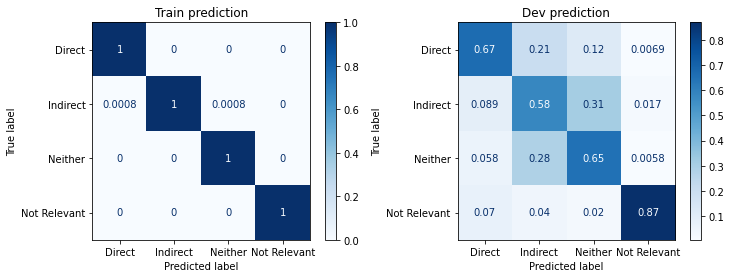

In [15]:
plot_confusion_matrix_traindev('../results/sent_sim_PubMedBERT_noshuffle/', ckpt_step=9999)

[Experiment ../results/sent_sim2_PubMedBERT_noshuffle/, step 8000]
- Train set performance
    - Accuracy: 0.999568 (4631/4633)
    - Macro F1: 0.999577
- Dev set performance
    - Accuracy: 0.675042 (403/597)
    - Macro F1: 0.700254
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct       87       33       23        2      145
Indirect        0     1249        0        0     1249 | Indirect       19      117       39        4      179
 Neither        0        1     1483        0     1484 |  Neither       10       51      109        3      173
Not Rele        0        0        1      809      810 | Not Rele        3        3        4       90      100
Pred cnt     1090     1250     1484      809     4633 | Pred cnt      119      204      175       99      597


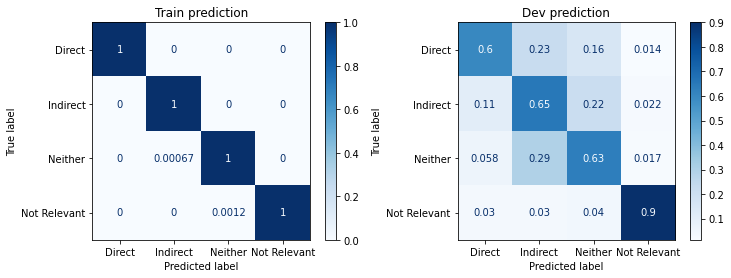

In [16]:
plot_confusion_matrix_traindev('../results/sent_sim2_PubMedBERT_noshuffle/', ckpt_step=8000)

## Examples / results

In [17]:
results_dir = '../results/sent_rel_BlueBERT-Large_noshuffle/'
ckpt_step = 9999

with open(os.path.join(results_dir, f'results_train_{ckpt_step}.pkl'), 'rb') as fd:
    train_results = pickle.load(fd)
with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
    dev_results = pickle.load(fd)
    
assert len(train_results) == len(df_train)
assert len(dev_results) == len(df_dev)

In [18]:
tokenizer = transformers.AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

In [19]:
def print_example(idx, dataset='train'):
    if dataset == 'train':
        row = df_train.iloc[idx]
    elif dataset == 'dev':
        row = df_test.iloc[idx]
    else:
        raise ValueError(f'Wrong dataset: {dataset}')
        
    row_id, hadm_id, assessment, plan, relation = \
        (row['ROW ID'], row['HADM ID'], row['Assessment'], row['Plan Subsection'], row['Relation'])
    print(f'[{dataset.upper()} example #{idx}, ROW_ID:{row_id:7}, HADM_ID:{hadm_id:7}]')
    num_assess_tokens = len(tokenizer.encode(assessment, add_special_tokens=False))
    print(f'- Assessment ({num_assess_tokens} tokens): \n{assessment}')
    num_plan_tokens = len(tokenizer.encode(plan, add_special_tokens=False))
    print(f'- Plan Subsection ({num_plan_tokens} tokens): \n{plan}')
    print(f'- Relation: {relation} (label {relation_to_label[relation]})')

In [20]:
print_example(0)

[TRAIN example #0, ROW_ID: 701359, HADM_ID: 186454]
- Assessment (53 tokens): 
51 yr old F with a history of 3V CAD, confirmed on C. cath during this
   admission, EF of 40%, who is transferred to CCU for monitoring of
   recurrent chest pain. Plan for CABG today to revascularize due to
   3-vessel disease.
- Plan Subsection (164 tokens): 
# CORONARIES: Patient with 3 vessel disease on cath. Previously found
   to be the case in [**2174**], but had been treated medically. On the floor,
   patient with recurrent chest pain and EKG changes, concerning for
   further ischemia. Chest pain has been controlled on nitro gtt. Patient
   in CCU for monitoring; plan for CABG today.
   - continue nitro gtt
   - if has further CP, would uptitrate nitro, and contact [**Name2 (NI) 9339**] and
   attending for potential balloon pump vs. urgent CABG
   - appreciate CT [**Doctor First Name 91**] recs
   - continue [**Last Name (LF) **], [**First Name3 (LF) 119**], ACE-i, simvastatin
- Relation: Direct 

In [21]:
def print_results(idx, dataset='train'):
    if dataset == 'train':
        row, result = df_train.iloc[idx], train_results[idx]
    elif dataset == 'dev':
        row, result = df_dev.iloc[idx], dev_results[idx]
    else:
        raise ValueError(f'Wrong dataset: {dataset}')
    
    row_id, hadm_id, assessment, plan, relation = \
        (row['ROW ID'], row['HADM ID'], row['Assessment'], row['Plan Subsection'], row['Relation'])
    assert row_id == result['row_id'] and hadm_id == result['hadm_id'] and relation_to_label[relation] == result['label']
    logits = result['logits']
    probs = np.exp(logits) / np.sum(np.exp(logits))
    pred = np.argmax(logits)
    correct = pred == relation_to_label[relation]
    color = "green" if correct else "red"
        
    print(f'[{dataset.upper()} example #{idx}, ROW_ID:{row_id:7}, HADM_ID:{hadm_id:7}]')
    num_assess_tokens = len(tokenizer.encode(assessment, add_special_tokens=False))
    print(f'- Assessment ({num_assess_tokens} tokens): \n{assessment}')
    num_plan_tokens = len(tokenizer.encode(plan, add_special_tokens=False))
    print(f'- Plan Subsection ({num_plan_tokens} tokens): \n{plan}')
    print(f'- Relation  : {relation} (label {relation_to_label[relation]})')
    print(f'- Prediction: {textcolor(label_to_relation[pred] + " (label " + str(pred) + ")", color)}')\
    
    for i in range(4):
        prob_str = f'  {i}) {label_to_relation[i]:>12} {probs[i]:.4f}'
        print(textbf(prob_str) if i == pred else prob_str)
    

In [22]:
print_results(0, 'dev')

[DEV example #0, ROW_ID: 576487, HADM_ID: 112508]
- Assessment (51 tokens): 
A 60 year old woman with recurrent ALL with CNS involvement s/p Omaya
   removal due to VRE contamination & SDH evacuation.  She is now doing
   well and awake s/p extubation, afebrile and her WBC count is trending
   downward.
- Plan Subsection (97 tokens): 
CNS VRE:  S/P Omaya removal, on linezolid for greater CNS penetration
   despite risk of CNS penetration. No TEE performed.
   - continue linezolid (D1=[**4-16**]), course to be determined by TEE (4 vs 8
   weeks) gentamicin D/C
d per ID
   - f/u culture data and sensitivities
   - TEE deferred at this time.
   - f/u tigacycline sensitivities for long-term therapy
- Relation  : Direct (label 0)
- Prediction: Indirect (label 1)
  0)       Direct 0.0038
  1)     Indirect 0.9962
  2)      Neither 0.0000
  3) Not Relevant 0.0000


In [23]:
print_results(2, 'dev')

[DEV example #2, ROW_ID: 576487, HADM_ID: 112508]
- Assessment (51 tokens): 
A 60 year old woman with recurrent ALL with CNS involvement s/p Omaya
   removal due to VRE contamination & SDH evacuation.  She is now doing
   well and awake s/p extubation, afebrile and her WBC count is trending
   downward.
- Plan Subsection (70 tokens): 
ALL:  Currently day +43 s/p hyper-CVAD.  She is also s/p intrathecal
   MTX and DLI this admission.  Per BMT, will need further treatment for
   CNS lymphoma in the future.
   - f/u BMT recommendations
   - follow CBC/diff
   - continue acyclovir, micafungin in addition to linezolid
- Relation  : Indirect (label 1)
- Prediction: Indirect (label 1)
  0)       Direct 0.0005
  1)     Indirect 0.9995
  2)      Neither 0.0000
  3) Not Relevant 0.0000


In [24]:
print_results(123, 'dev')

[DEV example #123, ROW_ID: 424348, HADM_ID: 189961]
- Assessment (32 tokens): 
47 yo w HTN, HPLD admitted to the floor for CHF, now admitted to CCU
   for acute STEMI s/p stent of 100% LAD occlusion.
- Plan Subsection (44 tokens): 
FEN: Cardiac Diet
   ACCESS: PIV
   PROPHYLAXIS:
   -DVT ppx held as pt on integrillin
   -Pain managment with tylenol
   -Bowel regimen: senna, docusate
   CODE: full
   DISPO: CCU
- Relation  : Not Relevant (label 3)
- Prediction: Not Relevant (label 3)
  0)       Direct 0.0000
  1)     Indirect 0.0000
  2)      Neither 0.0000
  3) Not Relevant 1.0000
